<a href="https://colab.research.google.com/github/ashp902/blind-label/blob/main/Dataset_Folder_Structure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Contribution 1: Dataset Folder Structure for Food Label OCR

This notebook demonstrates my contribution to the **dataset design and folder structure**
for the Accessible Food Label Reader project.

Goals:

- Define a clear, reproducible dataset layout for front/back food package images.
- Include split information (train/val/test).
- Provide a metadata index (`metadata/index.csv`) that links images to labels and text.
- Generate a small toy dataset so the structure is runnable and testable in isolation.


In [1]:
from pathlib import Path

# Root of the dataset inside Colab
DATA_ROOT = Path("/content/food_label_ocr_dataset")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

print("Dataset root:", DATA_ROOT.as_posix())

# Define folder structure
SUBDIRS = [
    "raw/front",               # Raw front images (as captured)
    "raw/back",                # Raw back images
    "processed/train/images",  # Preprocessed label crops for training
    "processed/train/labels",
    "processed/val/images",
    "processed/val/labels",
    "processed/test/images",
    "processed/test/labels",
    "metadata",                # CSV/JSON with annotations and splits
    "tmp_crops",               # Temporary crops from OpenCV region detection
]

for rel in SUBDIRS:
    path = DATA_ROOT / rel
    path.mkdir(parents=True, exist_ok=True)

print("\nCreated folder structure:\n")
for path in sorted(DATA_ROOT.rglob("*")):
    indent = "  " * (len(path.relative_to(DATA_ROOT).parts) - 1)
    if path.is_dir():
        print(f"{indent}{path.name}/")


Dataset root: /content/food_label_ocr_dataset

Created folder structure:

metadata/
processed/
  test/
    images/
    labels/
  train/
    images/
    labels/
  val/
    images/
    labels/
raw/
  back/
  front/
tmp_crops/


In [ ]:
## dataset generation

To make the dataset structure **demonstrable**, I generate a tiny synthetic dataset
with three products. Each product has:

- A *front* image (product name + highlights).
- A *back* image (ingredients + nutrition + expiry).
- Entries written to `metadata/index.csv` describing split, view (front/back), and raw text.

This shows that the folder structure is **actually used** in code, not just theoretical.


In [2]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

DATA_ROOT = Path("/content/food_label_ocr_dataset")

products = [
    {
        "product_id": "cereal_001",
        "name": "Crunchy Oat Cereal",
        "front_text": "Crunchy Oat Cereal\nHigh in Fiber\nNet wt. 500 g",
        "back_text": (
            "INGREDIENTS: Wholegrain Oats (70%), Sugar, Honey, Salt, Vitamin B6.\n"
            "NUTRITION FACTS (per 30 g): Calories 120, Protein 4 g, Fat 2 g, Sugar 6 g.\n"
            "BEST BEFORE: 15/09/2026\n"
            "USAGE: Store in a cool, dry place."
        ),
    },
    {
        "product_id": "juice_001",
        "name": "Orange Blast Juice",
        "front_text": "Orange Blast Juice\n100% Vitamin C\n1 Litre",
        "back_text": (
            "INGREDIENTS: Water, Orange Juice Concentrate (30%), Sugar, Vitamin C.\n"
            "NUTRITION FACTS (per 200 ml): Calories 90, Protein 0 g, Fat 0 g, Sugar 20 g.\n"
            "BEST BEFORE JAN 2026\n"
            "USAGE: Refrigerate after opening. Use within 3 days."
        ),
    },
    {
        "product_id": "choc_001",
        "name": "Dark Choco Bar",
        "front_text": "Dark Choco Bar 70%\nRich Cocoa Taste\n100 g",
        "back_text": (
            "INGREDIENTS: Cocoa Mass, Sugar, Cocoa Butter, Emulsifier (Soy Lecithin), "
            "Natural Vanilla Flavour.\n"
            "ALLERGENS: Contains Soy. May contain Milk and Tree Nuts.\n"
            "NUTRITION FACTS (per 25 g): Calories 140, Protein 2 g, Fat 9 g, Sugar 12 g.\n"
            "USE BY: 03-2025\n"
            "USAGE: Store in a cool, dry place away from sunlight."
        ),
    },
]

def render_text_image(text: str, size=(512, 256), font_size=24) -> Image.Image:
    """Render multiline text onto a simple grayscale image."""
    img = Image.new("L", size, color=255)
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", font_size)
    except OSError:
        font = ImageFont.load_default()
    x, y = 10, 10
    for line in text.split("\n"):
        draw.text((x, y), line, font=font, fill=0)
        y += font_size + 4
    return img

rows = []

splits = ["train", "val", "test"]

for prod in products:
    for view in ["front", "back"]:
        text_key = f"{view}_text"
        img = render_text_image(prod[text_key])

        split = random.choice(splits)
        img_filename = f"{prod['product_id']}_{view}.png"
        img_path = DATA_ROOT / "processed" / split / "images" / img_filename
        img_path.parent.mkdir(parents=True, exist_ok=True)
        img.save(img_path)

        rows.append(
            {
                "product_id": prod["product_id"],
                "product_name": prod["name"],
                "view": view,  # "front" or "back"
                "split": split,
                "image_path": str(img_path.relative_to(DATA_ROOT)),
                "raw_text": prod[text_key].replace("\n", " "),
            }
        )

meta_df = pd.DataFrame(rows)
meta_csv = DATA_ROOT / "metadata" / "index.csv"
meta_df.to_csv(meta_csv, index=False)

print("Metadata written to:", meta_csv.as_posix())
meta_df.head()


Metadata written to: /content/food_label_ocr_dataset/metadata/index.csv


,product_id,product_name,view,split,image_path,raw_text
0,cereal_001,Crunchy Oat Cereal,front,train,processed/train/images/cereal_001_front.png,Crunchy Oat Cereal High in Fiber Net wt. 500 g
1,cereal_001,Crunchy Oat Cereal,back,train,processed/train/images/cereal_001_back.png,"INGREDIENTS: Wholegrain Oats (70%), Sugar, Hon..."
2,juice_001,Orange Blast Juice,front,val,processed/val/images/juice_001_front.png,Orange Blast Juice 100% Vitamin C 1 Litre
3,juice_001,Orange Blast Juice,back,train,processed/train/images/juice_001_back.png,"INGREDIENTS: Water, Orange Juice Concentrate (..."
4,choc_001,Dark Choco Bar,front,val,processed/val/images/choc_001_front.png,Dark Choco Bar 70% Rich Cocoa Taste 100 g


product_id                                          cereal_001
product_name                                Crunchy Oat Cereal
view                                                     front
split                                                    train
image_path         processed/train/images/cereal_001_front.png
raw_text        Crunchy Oat Cereal High in Fiber Net wt. 500 g
Name: 0, dtype: object


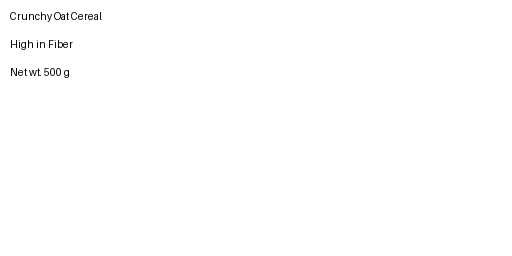

In [3]:
from IPython.display import display

example = meta_df.iloc[0]
print(example)

img_path = DATA_ROOT / example["image_path"]
display(Image.open(img_path))
